In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [3]:
geo = pd.read_csv('../datasets/socio.csv')
columns = ['sex', 'relation', 'is_parent', 'has_pets', 'age', 'mean_tr', 'median_tr', 'tr_per_month']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [4]:
geo['age'] = geo['age'].apply(lambda x: float(x))
geo['sex'] = geo['sex'].apply(lambda x: str(x))
geo['relation'] = geo['relation'].apply(lambda x: str(x))
geo['is_parent'] = geo['is_parent'].apply(lambda x: str(x))
geo['has_pets'] = geo['has_pets'].apply(lambda x: str(x))

In [5]:
geo_train, geo_test = train_test_split(geo, test_size=0.1)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [6]:
geo_types = get_nodes_type(geo)
geo_types

{'sex': 'disc',
 'relation': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'age': 'cont',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 'tr_per_month': 'cont'}

In [7]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [8]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

# Hill Climbing

# Дискретная структра + смешанные параметры

In [9]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_types)

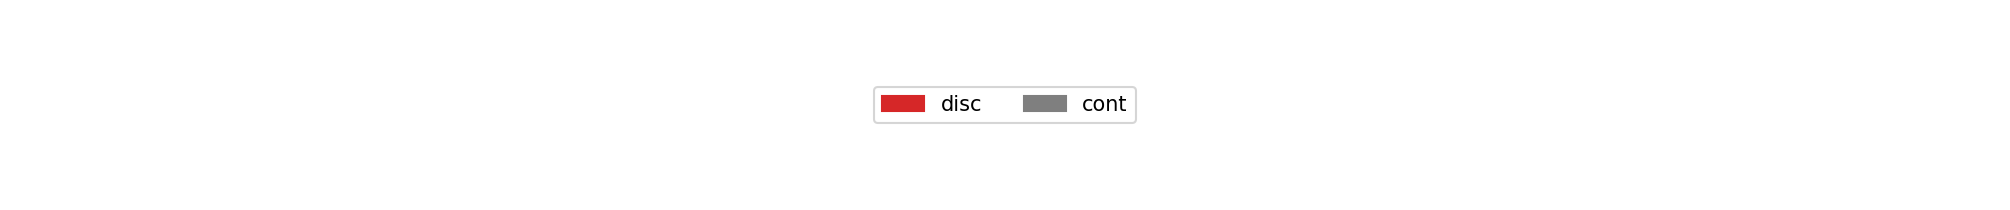

In [10]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [11]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [12]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [13]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

In [14]:
acc

{'sex': 0.63, 'relation': 0.22, 'is_parent': 0.72, 'has_pets': 0.97}

In [15]:
rmse

{'age': 12.33, 'mean_tr': 7001.66, 'median_tr': 5616.86, 'tr_per_month': 20.62}

# Смешанная структура + смешанные параметры

In [16]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_types)

c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:260: RuntimeWarning: overflow encountered in double_scalars
  delta_score = delta1 + delta2
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-

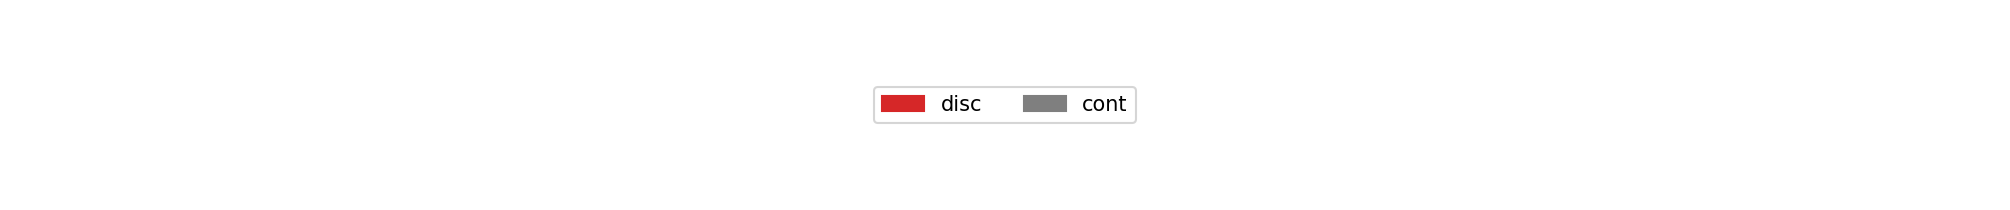

In [17]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [18]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [19]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [20]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

In [21]:
acc

{'sex': 0.63, 'relation': 0.21, 'is_parent': 0.72, 'has_pets': 0.97}

In [22]:
rmse

{'age': 12.34, 'mean_tr': 6869.92, 'median_tr': 5599.34, 'tr_per_month': 20.78}

# Дискретная стурктура + дискретные параметры

In [23]:
geo_new_types = {'sex': 'disc',
 'relation': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'age': 'disc',
 'mean_tr': 'disc',
 'median_tr': 'disc',
 'tr_per_month': 'disc'}

In [24]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_new_types)

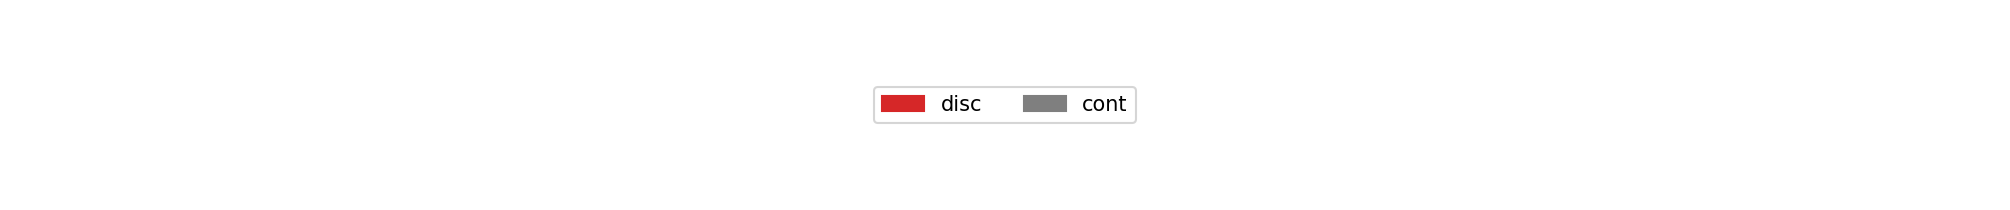

In [25]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [26]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [27]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [28]:
test_discrete = copy(geo_test)

In [29]:
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [30]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,sex,relation,is_parent,has_pets,age,mean_tr,median_tr,tr_per_month
0,1,2,0,0,4,2,3,2
1,2,6,0,0,1,0,1,4
2,2,1,0,0,3,3,3,1
3,1,2,0,0,0,0,0,3
4,2,1,0,0,3,3,4,0
...,...,...,...,...,...,...,...,...
374,2,4,1,0,3,2,2,4
375,2,6,0,0,0,0,0,1
376,2,6,0,0,2,2,2,3
377,2,6,0,0,2,1,1,2


In [31]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [32]:
acc

{'sex': 0.63,
 'relation': 0.21,
 'is_parent': 0.72,
 'has_pets': 0.97,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [34]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [35]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age','mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [36]:
mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)

17.41132831124625

In [37]:
mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)

14746.560673404058

In [38]:
mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)

15832.73893772414

In [39]:
mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)

56.078169707301136

# Смешанная структура + дискретные параметры

In [40]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_new_types)

c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:260: RuntimeWarning: overflow encountered in double_scalars
  delta_score = delta1 + delta2
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-

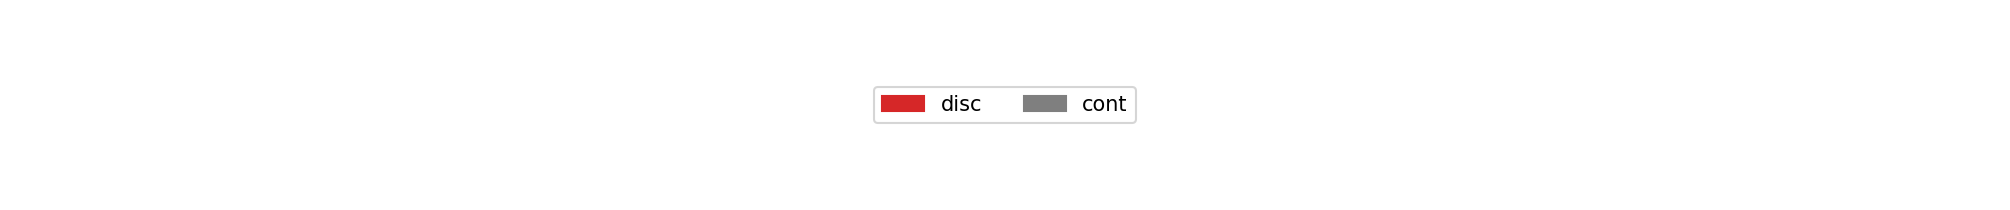

In [41]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [42]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [43]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [44]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [45]:
acc

{'sex': 0.63,
 'relation': 0.22,
 'is_parent': 0.72,
 'has_pets': 0.97,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [46]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [47]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [48]:
mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)

17.626717996697298

In [49]:
mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)

14471.583377020164

In [50]:
mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)

18498.87134072433

In [51]:
mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)

47.94620183628963

# EVO

# Дискретная стурктура + смешанные параметры

In [52]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 6.813371428571429
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 4.518442857142858
Generation num: 1
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 4.518442857142858
Gen

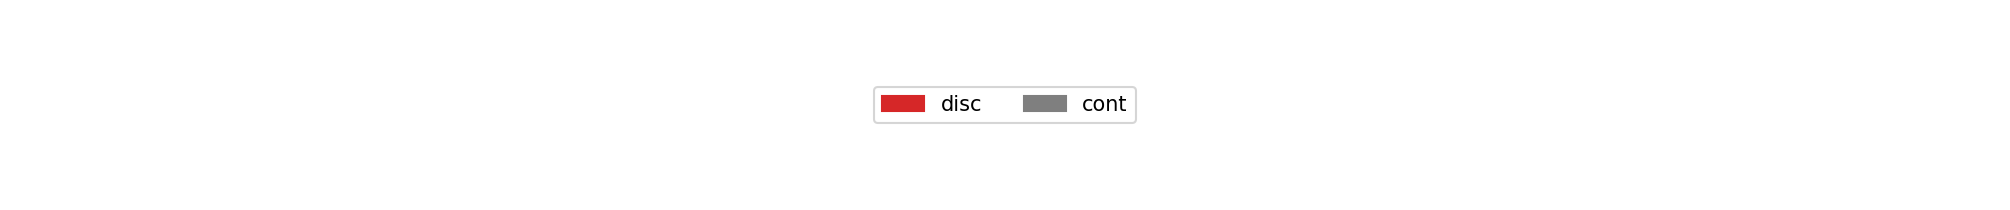

In [53]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [54]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [55]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [56]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

317


In [57]:
acc

{'sex': 0.64, 'relation': 0.22, 'is_parent': 0.72, 'has_pets': 0.97}

In [58]:
rmse

{'age': 12.33, 'mean_tr': 6888.21, 'median_tr': 5598.24, 'tr_per_month': 20.14}

# Смешанная структура + смешанные параметры

In [59]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is -5.271827374962802e+304
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.9 min
Best metric is -5.271827374962802e+304
Generation num: 1
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 1.3 min
Best metric is -5.271827374962802e+304
Generation num: 2
max_depth: 3, no improvements: 2
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 1.7 min
Best metric is -1.5815482124888406e+305
Generation num: 3
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'st

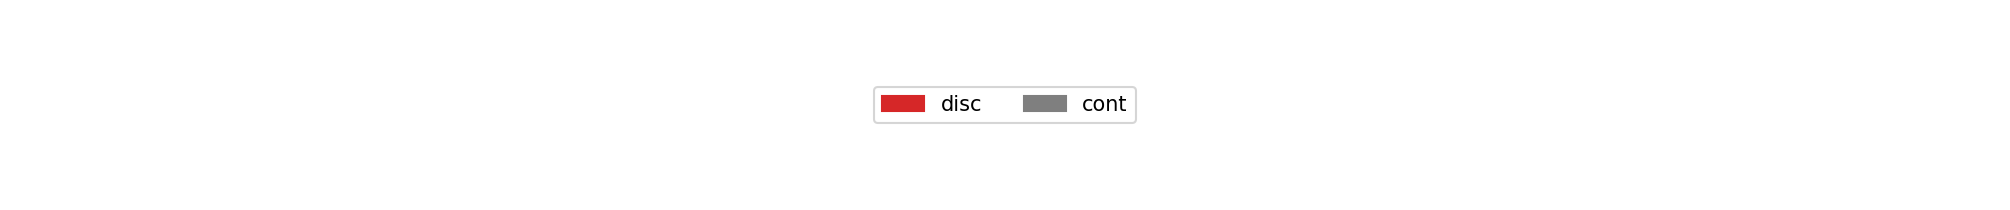

In [60]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [61]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [62]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [63]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

317


In [64]:
acc

{'sex': 0.64, 'relation': 0.22, 'is_parent': 0.72, 'has_pets': 0.97}

In [65]:
rmse

{'age': 11.11, 'mean_tr': 7008.31, 'median_tr': 5592.0, 'tr_per_month': 20.71}

# Дискретная структура + дискретные параметры

In [66]:
geo_new_types = {'sex': 'disc',
 'relation': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'age': 'disc',
 'mean_tr': 'disc',
 'median_tr': 'disc',
 'tr_per_month': 'disc'}

In [67]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 6.461028571428571
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 5.206642857142857
Generation num: 1
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 5.206642857142857
Generation num: 2
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no 

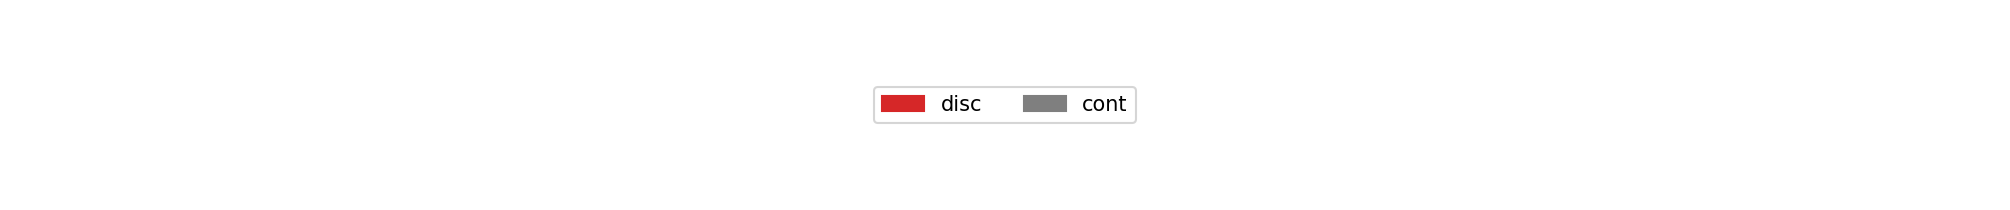

In [68]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [69]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [70]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [71]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [72]:
acc

{'sex': 0.64,
 'relation': 0.24,
 'is_parent': 0.72,
 'has_pets': 0.97,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [73]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [74]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [75]:
mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)

15.780026452084801

In [76]:
mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)

19060.86974306364

In [77]:
mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)

18418.549275036134

In [78]:
mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)


45.38235953690119

# Смешанная структура + дискретные параметры

In [79]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is -2.108730949985121e+305
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 1.1 min
Best metric is -2.108730949985121e+305
Generation num: 1
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 1.5 min
Best metric is -2.108730949985121e+305
Generation num: 2
max_depth: 3, no improvements: 2
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 's

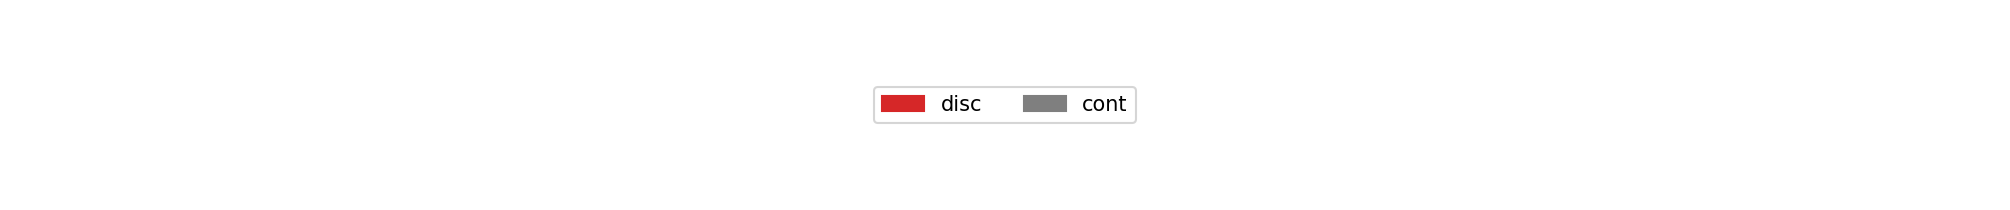

In [80]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [81]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [82]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [83]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [84]:
acc

{'sex': 0.64,
 'relation': 0.22,
 'is_parent': 0.72,
 'has_pets': 0.97,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [85]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [86]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [87]:
mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)

18.239971763159183

In [88]:
mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)

14315.244027246743

In [89]:
mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)

17334.11088264917

In [90]:
mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)

46.16091426521603